# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import CustomDataset, MLP, intialise_loaders, loss_fn

In [3]:
from common_utils import split_dataset, preprocess_dataset

random_seed = 0

def preprocess(df):
    X_train, y_train, X_test, y_test = split_dataset(df, ['filename', 'label'], 0.3, random_seed)
    
    return X_train, y_train, X_test, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

print(df['label'].value_counts())

X_train, y_train, X_test, y_test = preprocess(df)

label
pos    6202
neg    5855
Name: count, dtype: int64


3. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [4]:
n_splits = 5
def generate_cv_folds_for_batch_sizes(parameters, X, y):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    X_train_scaled_dict = collections.defaultdict(list)
    X_val_scaled_dict = collections.defaultdict(list)
    y_train_dict = collections.defaultdict(list)
    y_val_dict = collections.defaultdict(list)

    kf = KFold(n_splits = n_splits, shuffle=True, random_state=random_seed)
    for batch_size in parameters:
        for train_indices, val_indices in kf.split(X):
            X_train, X_val = X[train_indices], X[val_indices]
            y_train, y_val = y[train_indices], y[val_indices]

            scaler = preprocessing.StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            X_train_scaled_dict[batch_size].append(X_train_scaled)
            X_val_scaled_dict[batch_size].append(X_val_scaled)
            y_train_dict[batch_size].append(y_train)
            y_val_dict[batch_size].append(y_val)

    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

batch_sizes = [128, 256, 512, 1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)


4. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [5]:
def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, parameter_name):
    cross_validation_accuracies = {}
    cross_validation_times = {}
    n_epochs = 20

    for batch_size in batch_sizes:
        current_batch_size_validation_accuracies = []
        current_batch_size_training_time = []

        model = MLP(77, 128, 1)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        for split_index in range(n_splits):
            X_train = X_train_scaled_dict[batch_size][split_index]
            y_train = y_train_dict[batch_size][split_index]
            X_val = X_val_scaled_dict[batch_size][split_index]
            y_val = y_val_dict[batch_size][split_index]

            train_data = CustomDataset(X_train, y_train)
            val_data = CustomDataset(X_val, y_val)

            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

            model.train()
            for epoch in range(n_epochs):
                epoch_start_time = time.time()

                for X_batch, y_batch in train_loader:
                    optimizer.zero_grad()
                    y_pred = model(X_batch)
                    loss = loss_fn(y_pred, y_batch)
                    loss.backward()
                    optimizer.step()

                if epoch == n_epochs - 1: # track training time and validation accuracy of last epoch
                    epoch_end_time = time.time()
                    current_batch_size_training_time.append(epoch_end_time - epoch_start_time)

                    model.eval()
                    overall_accuracy = []
                    for X_batch, y_batch in val_loader:
                        y_pred = model(X_batch)

                        accuracy = (y_pred.round() == y_batch).float().mean()
                        accuracy = float(accuracy)
                        overall_accuracy.append(accuracy)

                    current_batch_size_validation_accuracies.append(sum(overall_accuracy) / len(overall_accuracy))

        cross_validation_accuracies[batch_size] = sum(current_batch_size_validation_accuracies) / len(current_batch_size_validation_accuracies)
        cross_validation_times[batch_size] = sum(current_batch_size_training_time) / len(current_batch_size_training_time)

    return cross_validation_accuracies, cross_validation_times


batch_sizes = [128, 256, 512, 1024]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')


5. Plot scatterplot of mean cross validation accuracies for the different batch sizes.

Text(0.5, 1.0, 'Cross-validation accuracy against Batch size')

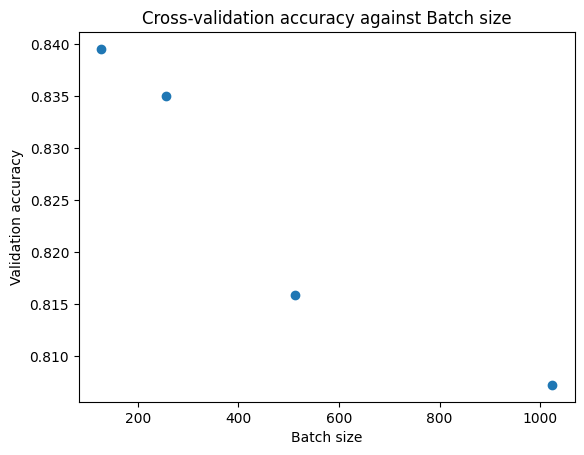

In [6]:
# YOUR CODE HERE
plt.scatter(cross_validation_accuracies.keys(), cross_validation_accuracies.values())
plt.xlabel("Batch size")
plt.ylabel("Validation accuracy")
plt.title("Cross-validation accuracy against Batch size")

6. Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [7]:
df = pd.DataFrame(cross_validation_times.items(), columns=["Batch Size", "Mean time to train last epoch"])
df

,Batch Size,Mean time to train last epoch
0,128,0.211343
1,256,0.140728
2,512,0.098840
3,1024,0.091284


Text(0.5, 0, 'Mean time to train last epoch')

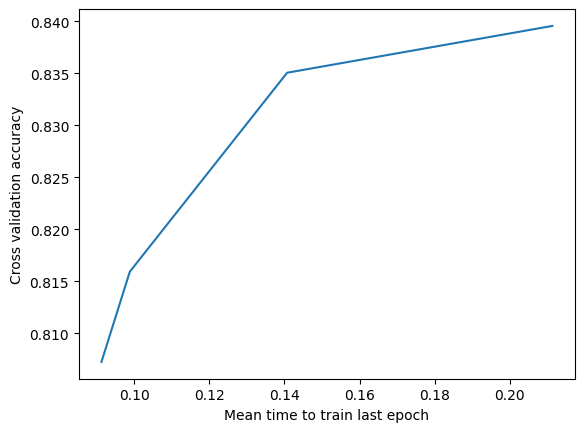

In [10]:
plt.plot(df["Mean time to train last epoch"], cross_validation_accuracies.values())
plt.ylabel("Cross validation accuracy")
plt.xlabel("Mean time to train last epoch")

`optimal_batch_size = 256`

I use the same logic as the Elbow method for determining the number of centroids to use in a k-means clustering. We can see that from `batch_size = 128` to `batch_size = 256`, we only have a small drop in cross-validation accuracy, while significantly reducing training time. However, if we move from `batch_size = 256` to `batch_size = 512`, the drop in cross-validation accuracy is a lot more significant than the improvement in training time. Any further increase in batch size does not yield significant improvements to training time. Hence, the optimal batch size I chose is 256